<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/topic-modeling-v2/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval
from os.path import exists

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NLTK
import nltk
import nltk.data
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import RegexpTokenizer

!pip install vaderSentiment
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Mount colab drive to google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load file from drive

In [8]:
raw_df = pd.DataFrame(columns=['text'], index=[0])
raw_df

,text
0,NaN


In [9]:
if not exists('/content/NLP-question-data'):
    !git clone https://github.com/EnsarIshakoglu/NLP-question-data.git

In [10]:
with open('/content/NLP-question-data/zen-pdr.txt', 'r') as f: # read out .txt file
  data = f.read()

In [11]:
raw_df.loc[0]['text'] = data
raw_df

,text
0,\n\n\nPersonal Development Report Zen Visser\n...


## Clean data

In [12]:
nltk.download('punkt')

sentences = np.array([])
# Tokenise to sentences
for x in raw_df['text']:
    new = np.array(nltk.sent_tokenize(x))
    sentences = np.append(sentences, new)

sentences.shape
df_tokenise = pd.DataFrame(sentences, columns=["text"])

print(f'Shape: {df_tokenise.shape}')
df_tokenise.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Shape: (508, 1)


,text
0,\n\n\nPersonal Development Report Zen Visser\n...
1,The learning outcomes are as follows: Developm...
2,The group project is a platform on which users...
3,These datasets can be grouped into projects to...
4,These users can be Maintainers of the project ...


In [13]:
df_filtered = df_tokenise

In [14]:
# Remove <pre> tags
df_filtered['text'] = df_filtered['text'].replace('<pre.*?</pre>','', regex=True)
df_filtered['text'] = df_filtered['text'].replace('<code.*?</code>','', regex=True)
df_filtered.iloc[0]['text']

'\n\n\nPersonal Development Report Zen Visser\nMade by: Zen Visser,\nSchool Year: 2021,\nSchool: Fontys Hogeschool Eindhoven\n\n\n\n\n\n\n\nTable of contents\nIntroduction\t3\nLearning outcome table\t5\nLatest evaluation\t5\nMy own evaluation\t5\nLearning outcome: Development and Deployment of Enterprise Software\t6\nSelf-assessment\t6\nLearning process description\t6\nFeedback\t9\nFirst Evaluation\t9\nSecond Evaluation\t9\nThird Evaluation\t9\nLearning outcome: Context-Based Research\t10\nSelf-assessment\t10\nLearning process description\t10\nFeedback\t12\nFirst Evaluation\t12\nSecond Evaluation\t12\nThird Evaluation\t12\nLearning outcome: Preparation for Life-Long Learning\t13\nSelf-assessment\t13\nLearning process description\t13\nFeedback\t16\nFirst Evaluation\t16\nSecond Evaluation\t16\nThird Evaluation\t16\nLearning outcome: Scalable Architectures\t17\nSelf-assessment\t17\nLearning process description\t17\nFeedback\t19\nFirst Evaluation\t19\nSecond Evaluation\t19\nThird Evaluatio

In [15]:
# Remove html tags
df_filtered['text'] = df_filtered['text'].str.replace(r'<[^<>]*>', '', regex=True)

In [16]:
# Remove punctuation
df_filtered['text'] = df_filtered['text'].replace('[^\w\s]','', regex=True)
df_filtered['text'] = df_filtered['text'].replace(r'\s+|\\n', ' ', regex=True) 

In [17]:
# View example of text
for i in range(5):
  print(df_filtered.iloc[i]['text'])
  print('\n')

 Personal Development Report Zen Visser Made by Zen Visser School Year 2021 School Fontys Hogeschool Eindhoven Table of contents Introduction 3 Learning outcome table 5 Latest evaluation 5 My own evaluation 5 Learning outcome Development and Deployment of Enterprise Software 6 Selfassessment 6 Learning process description 6 Feedback 9 First Evaluation 9 Second Evaluation 9 Third Evaluation 9 Learning outcome ContextBased Research 10 Selfassessment 10 Learning process description 10 Feedback 12 First Evaluation 12 Second Evaluation 12 Third Evaluation 12 Learning outcome Preparation for LifeLong Learning 13 Selfassessment 13 Learning process description 13 Feedback 16 First Evaluation 16 Second Evaluation 16 Third Evaluation 16 Learning outcome Scalable Architectures 17 Selfassessment 17 Learning process description 17 Feedback 19 First Evaluation 19 Second Evaluation 19 Third Evaluation 20 Learning outcome Development and Operations DevOps 21 Selfassessment 21 Learning process descript

In [18]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['text'] = df_filtered['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,text
0,Personal Development Report Zen Visser Made Ze...
1,The learning outcomes follows Development Depl...
2,The group project platform users view visualiz...
3,These datasets grouped projects different user...
4,These users Maintainers project people interes...


In [19]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['text'] = df_filtered['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,text
0,Personal Development Report Zen Visser Made Ze...
1,The learn outcome follow Development Deploymen...
2,The group project platform user view visualize...
3,These datasets grouped project different user add
4,These user Maintainers project people interest...


## Prepare data

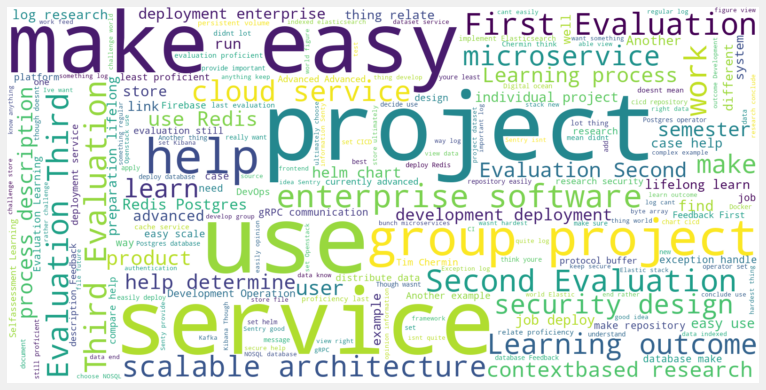

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(' '.join(df_filtered['text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df_filtered['text'])
vectorizer.transform(df_filtered['text']).toarray()

array([[3, 4, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
X = df_filtered['text']

In [23]:
vectorised = vectorizer.transform(X)

In [24]:
vectorised.shape

(508, 772)

## Create model

In [25]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

results = pd.DataFrame(df_filtered['text'])

for i in df_filtered['text'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
results['sentiment'] = sentiment_label_list
results['sentiment score'] = sentiment_score_list

In [26]:
results.head(10)

,text,sentiment,sentiment score
0,Personal Development Report Zen Visser Made Ze...,Positive,0.3400
1,The learn outcome follow Development Deploymen...,Positive,0.3400
2,The group project platform user view visualize...,Neutral,0.0000
3,These datasets grouped project different user add,Neutral,0.0000
4,These user Maintainers project people interest...,Positive,0.4588
5,For semester individual project I make platfor...,Positive,0.7845
6,Users add product yet database system add sour...,Neutral,0.0000
7,Users able report product source,Neutral,0.0000
8,Admins able add new store source category prod...,Neutral,0.0000
9,Some link provide document Google doc document,Neutral,0.0000


In [27]:
# Source: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 10, # number of topics
                                  random_state = 56,        # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
topic_df = pd.merge(results, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(topic_df.head(10))

,text,sentiment,sentiment score,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic
0,Personal Development Report Zen Visser Made Ze...,Positive,0.3400,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.77,10
1,The learn outcome follow Development Deploymen...,Positive,0.3400,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,The group project platform user view visualize...,Neutral,0.0000,0.01,0.01,0.01,0.30,0.61,0.01,0.01,0.01,0.01,0.01,5
3,These datasets grouped project different user add,Neutral,0.0000,0.01,0.74,0.01,0.01,0.01,0.01,0.01,0.16,0.01,0.01,2
4,These user Maintainers project people interest...,Positive,0.4588,0.01,0.01,0.01,0.01,0.28,0.01,0.01,0.62,0.01,0.01,8
5,For semester individual project I make platfor...,Positive,0.7845,0.01,0.01,0.01,0.23,0.01,0.01,0.14,0.32,0.27,0.01,8
6,Users add product yet database system add sour...,Neutral,0.0000,0.01,0.01,0.01,0.01,0.01,0.01,0.92,0.01,0.01,0.01,7
7,Users able report product source,Neutral,0.0000,0.02,0.02,0.02,0.02,0.02,0.02,0.68,0.02,0.02,0.18,7
8,Admins able add new store source category prod...,Neutral,0.0000,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,0.01,7
9,Some link provide document Google doc document,Neutral,0.0000,0.01,0.89,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2


In [28]:
# Source: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
# index names
docnames = ['Doc' + str(i) for i in range(len(results))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic,relevance_score
10,Topic10,3.099987
12,Topic10,4.099987
13,Topic10,3.099987
15,Topic7,5.099999
16,Topic10,4.099987
...,...,...
world,Topic4,6.100038
would,Topic9,8.551842
wouldnt,Topic4,5.099997
yet,Topic1,6.100016


In [29]:
# Source: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

#     tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,Topic10,[Evaluation]
1,Topic7,[product]
2,Topic9,[help]
3,Topic2,[deploy]
4,Topic6,[make]
5,Topic1,[Learning]
6,Topic3,[cloud]
7,Topic5,[security]
8,Topic8,[project]
9,Topic4,[get]


In [30]:
# split sentences by sentiment
positive_df = topic_df.loc[topic_df['sentiment'] == 'Positive']
neutral_df = topic_df.loc[topic_df['sentiment'] == 'Neutral']
negative_df = topic_df.loc[topic_df['sentiment'] == 'Negative']
print(positive_df.shape)
print(neutral_df.shape)
print(negative_df.shape)

(260, 14)
(228, 14)
(20, 14)
